## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
%matplotlib inline
sns.set()
%matplotlib nbagg

pd.options.display.precision = 15

## Umgebungsvariablen

In [3]:
failure_datapath = '''D:/jupyter-notebooks/LANL_Earthquake_Prediction/failure/'''
train_data_path = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/all/train.csv'''


### Load the full dataset

In [5]:
train_data = pd.read_csv(train_data_path, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

#  Data Exploration

## Acoustic data

In [6]:
train_data.acoustic_data.describe()

count    6.291454800000000e+08
mean     4.519467573700124e+00
std      1.073570724951096e+01
min     -5.515000000000000e+03
25%      2.000000000000000e+00
50%      5.000000000000000e+00
75%      7.000000000000000e+00
max      5.444000000000000e+03
Name: acoustic_data, dtype: float64

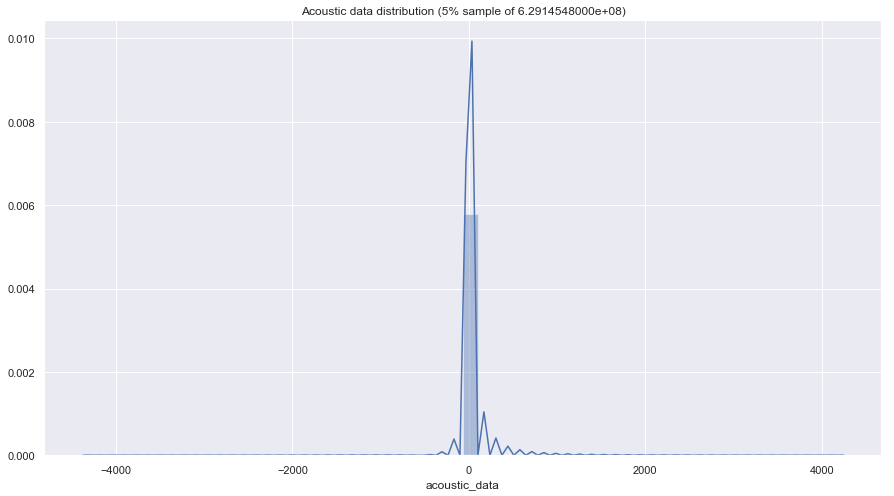

In [39]:
train_sample =train_data.sample(frac=0.05)
plt.figure(figsize=(15,8))
plt.title("Acoustic data distribution (5% sample of 6.2914548000e+08)")
ax = sns.distplot(train_sample.acoustic_data)
#quelle: https://www.kaggle.com/jsaguiar/seismic-data-exploration

Max Value beträgt: 5.4440000000e+03

In [29]:
train_sample.acoustic_data.quantile(0.9)

9.0

90% der accoustic daten liegen unter 9.

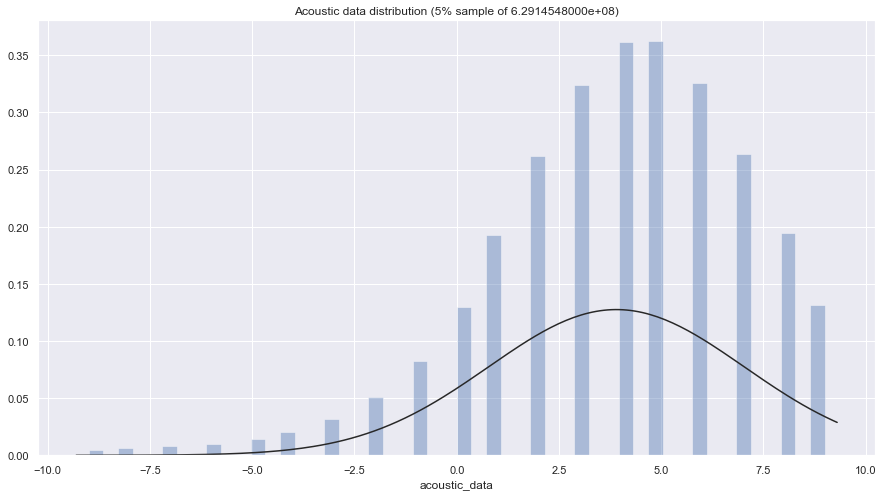

In [38]:
plt.figure(figsize=(15,8))
plt.title("Acoustic data distribution (5% sample of 6.2914548000e+08)")
ax = sns.distplot(train_sample.acoustic_data[train_sample.acoustic_data.between(-9, 9)], kde=False,fit=stats.norm)
#kde = whether to plot a gaussian kernel density estimate.
#quelle: https://www.kaggle.com/jsaguiar/seismic-data-exploration

## Time to failure

In [6]:
train_data.time_to_failure.describe()

count    6.2914548000e+08
mean     5.6782917130e+00
std      3.6726965194e+00
min      9.5503963166e-05
25%      2.6259969961e+00
50%      5.3497977412e+00
75%      8.1733955078e+00
max      1.6107400000e+01
Name: time_to_failure, dtype: float64

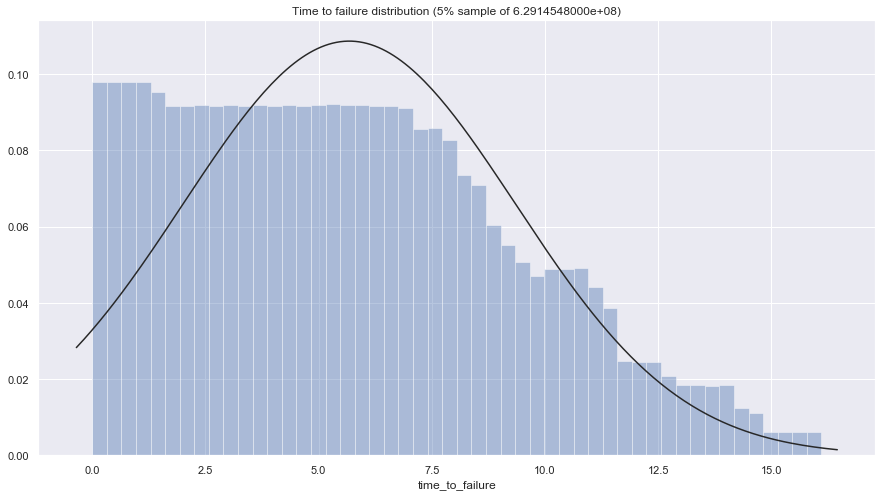

In [37]:
plt.figure(figsize=(15,8))
plt.title("Time to failure distribution (5% sample of 6.2914548000e+08)")
ax = sns.distplot(train_sample.time_to_failure,fit=stats.norm,kde=False )

Die Dauer bis zu einem Erdbeben liegt im Schnitt bei 5 - 7 Sekunden

# Data preparation
Die Trainingsdaten werden in die einzelnen Erdbeben aufgeteilt und je in ein separates File faulure gespeichert

## Die einzelnen Erdbeben voneinander trennen

In [8]:
#diff = a[n+1] - a[n].In case of a slip (time_to_failure near zero) the following number a[n] is higher than a[n+1]
failure_border = np.where(np.diff(train_data.time_to_failure) > 0)

In [9]:
failures = []
start = 0
for end in failure_border[0]:
    failures.append(train_data.iloc[start:end])
    start = end + 1

In [ ]:
for failure in failures:
    print(failure.describe())

### Save each failure to file

In [11]:
for failure in range(0,len(failures)):
    np.save('./failure/failure{}'.format(failure),failures[failure])

### load first earthquake

In [4]:
failure = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(0)))
failure.columns = ['acoustic_data','time_to_failure']

### Reduce datapoints from first earthquake

In [5]:
failure_reduced = failure.iloc[::2, :] #every second element
failure_reduced.reset_index(inplace=True)
failure_reduced.describe()

,index,acoustic_data,time_to_failure
count,2.828287000000000e+06,2.828287000000000e+06,2.828287000000000e+06
mean,2.828286000000000e+06,4.562173499365517e+00,7.349831092443366e-01
std,1.632912549474417e+06,2.342914389670302e+01,4.241720591890773e-01
min,0.000000000000000e+00,-4.621000000000000e+03,7.954809234400000e-04
25%,1.414143000000000e+06,2.000000000000000e+00,3.678966073200000e-01
50%,2.828286000000000e+06,5.000000000000000e+00,7.349977326199999e-01
75%,4.242429000000000e+06,7.000000000000000e+00,1.102098857900000e+00
max,5.656572000000000e+06,3.240000000000000e+03,1.469099983200000e+00


# Plot all earthquakes

In [11]:
def plot_acc_ttf_data(train, final_idx, init_idx=0, step=1, title="",
                      color1='orange', color2='blue'):
    '''quelle: https://www.kaggle.com/jsaguiar/seismic-data-exploration
       train: DataFrame mit column acoustic_data und time_to_failure
       init_idx: start index
       final_idx: end iundex
    '''
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(15, 8))
    fig.suptitle(title +' (step size: '+str(step)+')', fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=train.iloc[idx].time_to_failure.values, ax=ax2, color=color2)

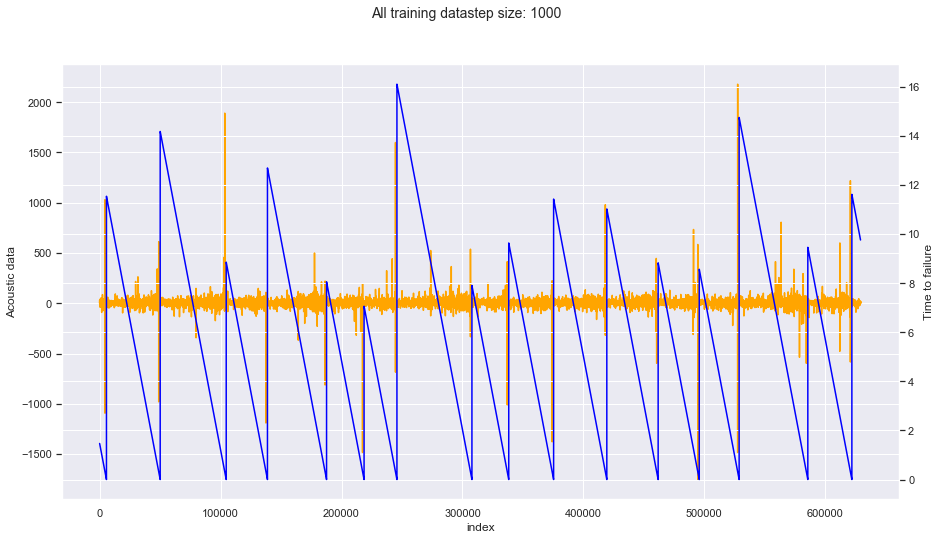

In [10]:
plot_acc_ttf_data(train_data,final_idx=len(train_data), step=1000, title="All training data")
print('Amount of samples: {}'.format(len(train_data)))

### Peaks

In [15]:
peaks = train_data[train_data.acoustic_data.abs() > 3000]
#print(peaks)
peaks.time_to_failure.describe()

count    392.000000000000000
mean       0.334221932599668
std        0.199341298228098
min        0.311197821230000
25%        0.314996150085000
50%        0.316896878660000
75%        0.318796294815000
max        2.600998755200000
Name: time_to_failure, dtype: float64

In [16]:
peaks = train_data[train_data.acoustic_data.abs() > 1000]
#print(peaks)
peaks.time_to_failure.describe()

count    11325.000000000000000
mean         0.644558013004459
std          1.321465214293448
min          0.310796265230000
25%          0.315496160450000
50%          0.316896836310000
75%          0.320296172000000
max          8.860599495399999
Name: time_to_failure, dtype: float64

In [17]:
peaks = train_data[train_data.acoustic_data.abs() > 500]
#print(peaks)
peaks.time_to_failure.describe()

count    29929.000000000000000
mean         1.029755067007894
std          1.893407348056042
min          0.309799922730000
25%          0.315497149350000
50%          0.318596904090000
75%          0.321495630420000
max          9.778795747700000
Name: time_to_failure, dtype: float64

Amount of samples: 5656573


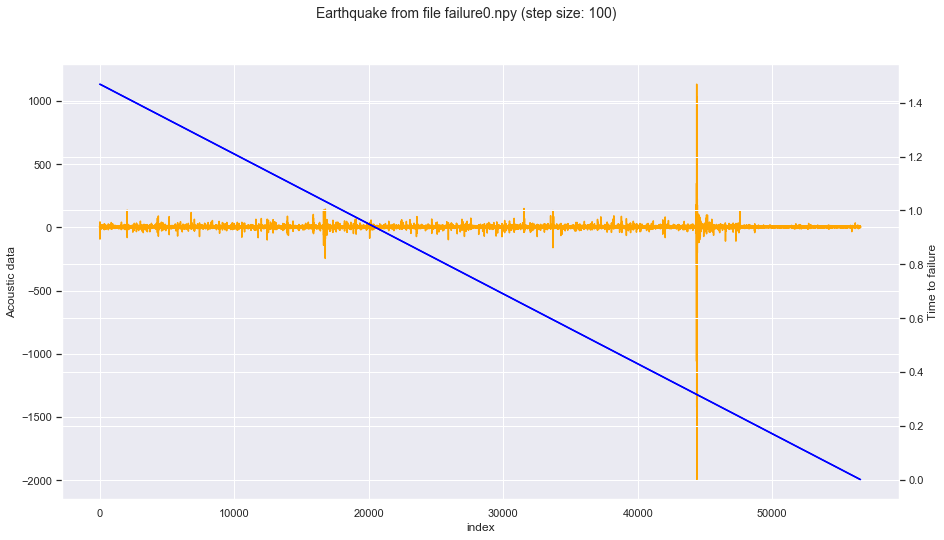

In [18]:
plot_acc_ttf_data(failure,final_idx=len(failure), step=100, title="Earthquake from file failure0.npy")
print('Amount of samples: {}'.format(len(failure)))

Der erste Test dauert nur ca. 1.4 Sekunden

Amount of samples: 44429303


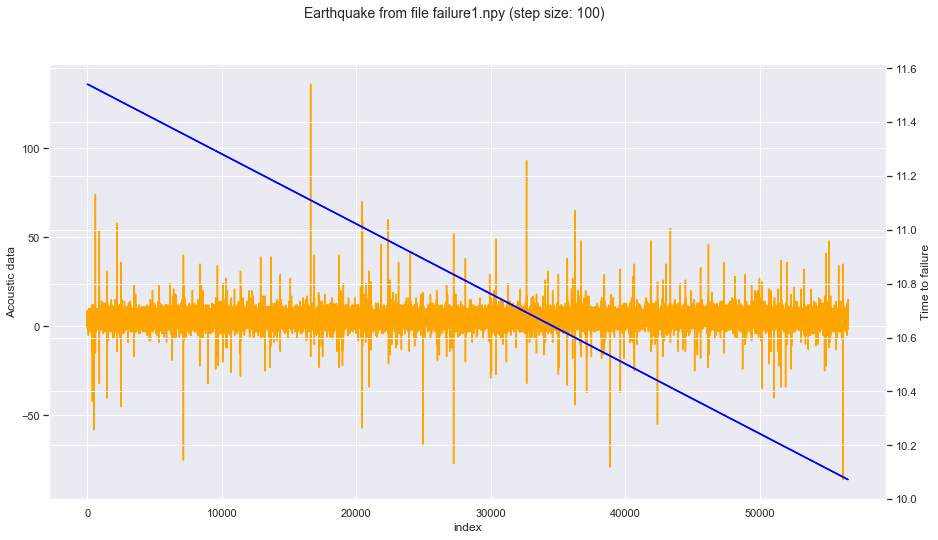

In [19]:
#load second earthquake
failure_2 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(1)))
failure_2.columns = ['acoustic_data','time_to_failure']
plot_acc_ttf_data(failure_2,final_idx=len(failure), step=100, title="Earthquake from file failure1.npy")
print('Amount of samples: {}'.format(len(failure_2)))

Amount of samples: 54591477


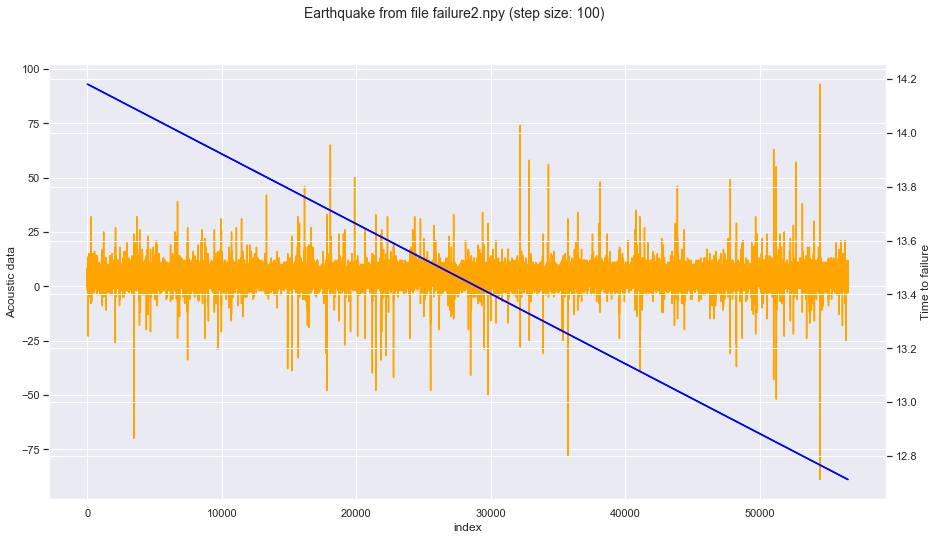

In [22]:
#load third earthquake
failure_3 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(2)))
failure_3.columns = ['acoustic_data','time_to_failure']
plot_acc_ttf_data(failure_3,final_idx=len(failure), step=100, title="Earthquake from file failure2.npy")
print('Amount of samples: {}'.format(len(failure_3)))

# sollten wir die 'Ausreisser' entfernen?

# Trends and Seasonality

## Augmented Dickey-Fuller test

### Was ist eine stationäre Zeitreihe?

Stationäre Zeitreihen weisen keine systematische Veränderung im Gesamtbild auf, d.h. es bestehen keine systematischen Änderungen im Mittel oder der Varianz, und es liegen keine streng periodischen Schwankungen vor. Anders ausgedrückt, schwanken solche Zeitreihen nicht regelmässig mit Jahresperiode, sie weisen keine mehrjährigen, zyklischen Verläufe auf und es lässt sich auch keine deutlich positive oder negative Steigung über einen längeren Zeitraum erkennen --> keine Saison und Trend - Komponenten enthalten. 

Wenn eine Zeitreihe stationär ist, kann das Modellieren einfacher sein. Statistische Modellierungsmethoden setzen voraus, dass die Zeitreihen stationär sind, um wirksam zu sein.

#### Null Hypothesis (H0): 
non-stationary. It has some time dependent structure.
#### Alternate Hypothesis (H1): 
meaning it is stationary. It does not have time-dependent structure.

#### Prepare Data

In [3]:
failure_1 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(0)))
failure_1.columns = ['acoustic_data','time_to_failure']
failure_reduced_1 = failure_1.iloc[::100, :] 
failure_reduced_1.reset_index(inplace=True)

#### adfuller and  Kwiatkowski-Phillips-Schmidt-Shin test test

In [8]:
print('Augmented Dickey-Fuller unit root test')
result_adfuller = adfuller(failure_reduced_1.acoustic_data)
print('ADF Statistic: %f' % result_adfuller[0])
print('p-value: %f' % result_adfuller[1])
print('Critical Values:')
for key, value in result_adfuller[4].items():
	print('\t%s: %.3f' % (key, value))

print('Kwiatkowski-Phillips-Schmidt-Shin test')
result_kpss = kpss(failure_reduced_1.acoustic_data)
print('kpss_stat: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

Augmented Dickey-Fuller unit root test
ADF Statistic: -31.884976
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Kwiatkowski-Phillips-Schmidt-Shin test
kpss_stat: 1.296516
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## Ist das Accoustic Signal stationär?

##### H0 kann verworfen werden. Das acoustic signal ist ein stationäres Signal.

## Analysen mit Window

### Rolling statistics mean and standardaviation

Prepare data

In [4]:
failure_1 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(0)))
failure_1.columns = ['acoustic_data','time_to_failure']
failure_reduced_1 = failure_1.iloc[::2, :] 
failure_reduced_1.reset_index(inplace=True)

<IPython.core.display.Javascript object>


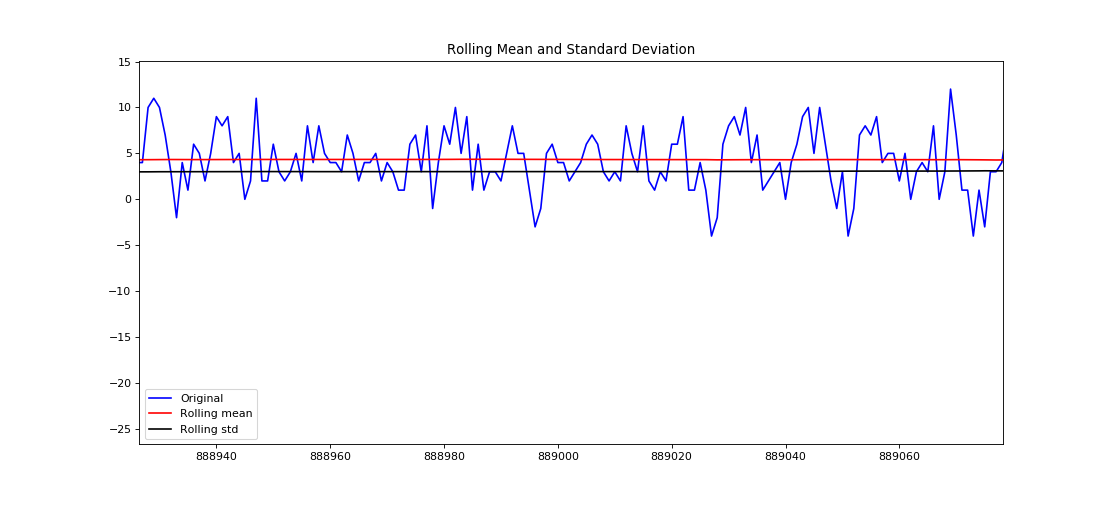

In [7]:
rolmean = failure_reduced_1[['acoustic_data']].rolling(1000).mean()
rolstd = failure_reduced_1[['acoustic_data']].rolling(1000).std()

orig = plt.plot(failure_reduced_1[['acoustic_data']], color='orange', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling mean')
rolstd = plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

Auch visuell bestätigt sich die Annahme, dass das Signal keine Trendkomponente enthaltet.

## Prepare data for windows plot

In [17]:
failure_2 = pd.DataFrame(np.load(failure_datapath+'/failure{}.npy'.format(1)))
failure_2.columns = ['acoustic_data','time_to_failure']
#failure_reduced_2 = failure_2.iloc[::2, :] 
#failure_reduced_2.reset_index(inplace=True)

In [22]:
window = 5000 #willkürlich gewählt --> sollte noch besprochen werden!

In [76]:
def plot_double_series(first_chunk,first_ylabel,second_chunk,second_ylabel,xlabel,title):
    # plot rolling mean
    fig, ax1 = plt.subplots(figsize=(15, 8))
    fig.suptitle(title, fontsize=14)

    ax2 = ax1.twinx()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(first_ylabel)
    ax2.set_ylabel(second_ylabel)
    p1 = sns.lineplot(data=first_chunk, ax=ax1, color='orange',label=first_ylabel)
    p2 = sns.lineplot(data=second_chunk, ax=ax2,label=second_ylabel)
    plt.legend(loc='best')
    plt.show()

In [78]:
def plot_triple_series(first_chunk,first_ylabel,second_chunk,second_ylabel,time_to_failure,xlabel,title):
    # plot rolling mean
    fig, ax1 = plt.subplots(figsize=(15, 8))
    fig.suptitle(title, fontsize=14)

    ax2 = ax1.twinx()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(first_ylabel)
    ax2.set_ylabel(second_ylabel)
    p1 = sns.lineplot(data=first_chunk, ax=ax1, color='orange',label=first_ylabel)
    p2 = sns.lineplot(data=second_chunk, ax=ax2,label=second_ylabel)
    p3 = sns.lineplot(data=time_to_failure, label='time_to_failure',color='black')
    plt.legend(loc='best')
    plt.show()

In [62]:
train = train_data
window_size = 150000

rolling_mean = []
rolling_std = []
rolling_skew = []
rolling_kurt = []
rolling_max = []
rolling_min = []
rolling_25Quantile = []

last_time_to_failure = []


init_idx = 0
for _ in range(int(np.round(len(train)/150000))):  # 629M / 150k = 4194
    x = train.iloc[init_idx:init_idx + window_size]
    last_time_to_failure.append(x.time_to_failure.values[-1])
    rolling_mean.append(x.acoustic_data.mean())
    rolling_std.append(x.acoustic_data.std())
    rolling_skew.append(x.acoustic_data.skew())
    rolling_kurt.append(x.acoustic_data.kurt())
    rolling_max.append(x.acoustic_data.max())
    rolling_min.append(x.acoustic_data.min())
    rolling_25Quantile.append(x.acoustic_data.quantile(.25, interpolation='midpoint'))
    
    init_idx += window_size
    
rolling_mean = np.array(rolling_mean)
rolling_std = np.array(rolling_std)
rolling_skew = np.array(rolling_skew)
rolling_kurt = np.array(rolling_kurt)
rolling_max = np.array(rolling_max)
rolling_min = np.array(rolling_min)
rolling_25Quantile = np.array(rolling_25Quantile)

last_time_to_failure = np.array(last_time_to_failure)


## Plot Windows

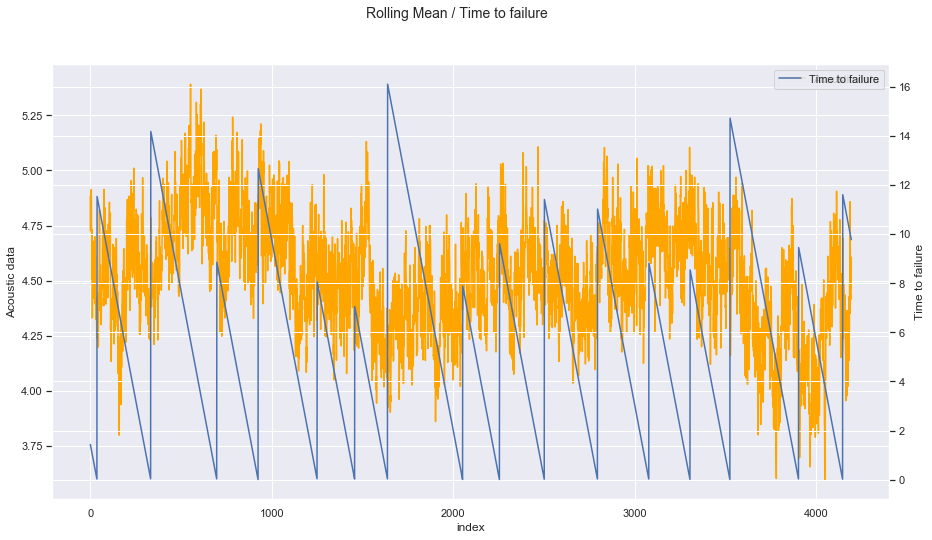

In [63]:
plot_double_series(rolling_mean,'Acoustic data',last_time_to_failure,'Time to failure','index','Rolling Mean / Time to failure')

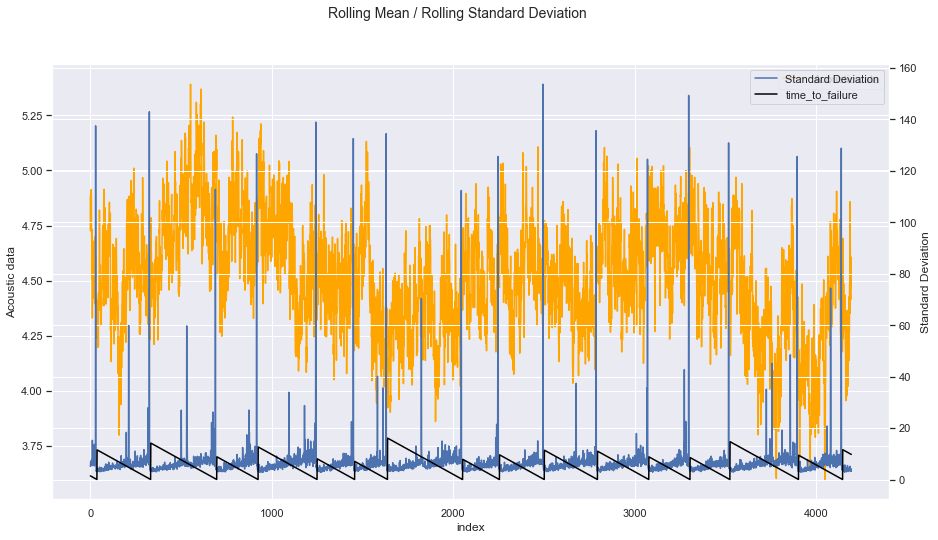

In [80]:
plot_triple_series(rolling_mean,'Acoustic data',rolling_std,'Standard Deviation',last_time_to_failure,'index','Rolling Mean / Rolling Standard Deviation')

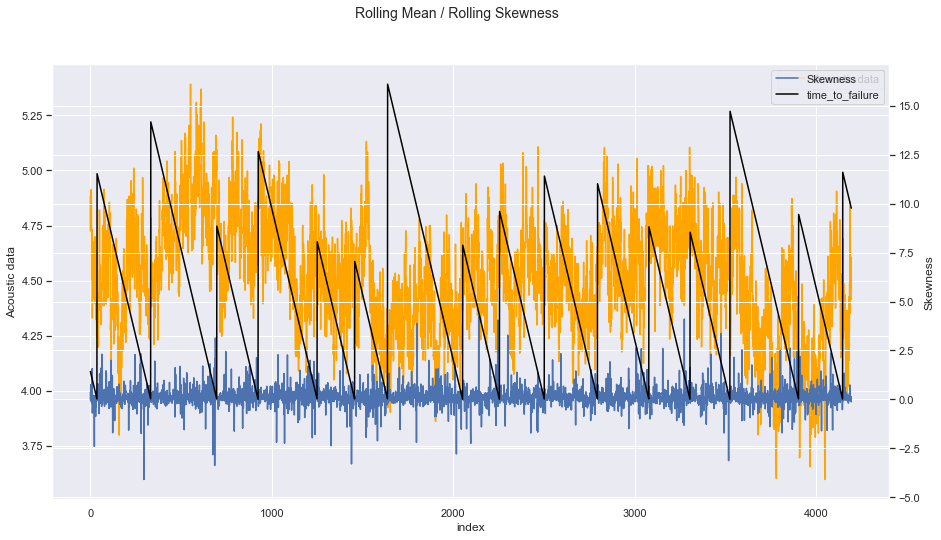

In [81]:
plot_triple_series(rolling_mean,'Acoustic data',rolling_skew,'Skewness',last_time_to_failure,'index','Rolling Mean / Rolling Skewness')

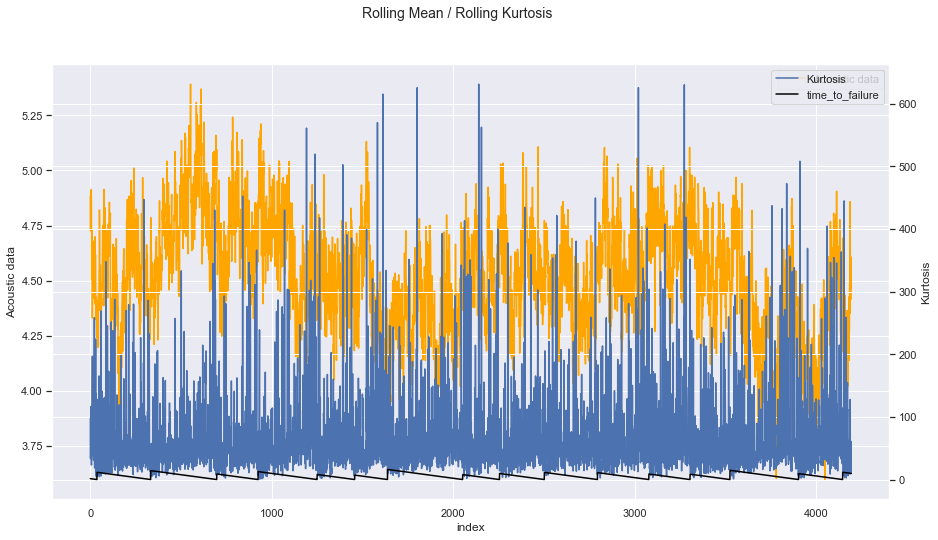

In [82]:
plot_triple_series(rolling_mean,'Acoustic data',rolling_kurt,'Kurtosis',last_time_to_failure,'index','Rolling Mean / Rolling Kurtosis')

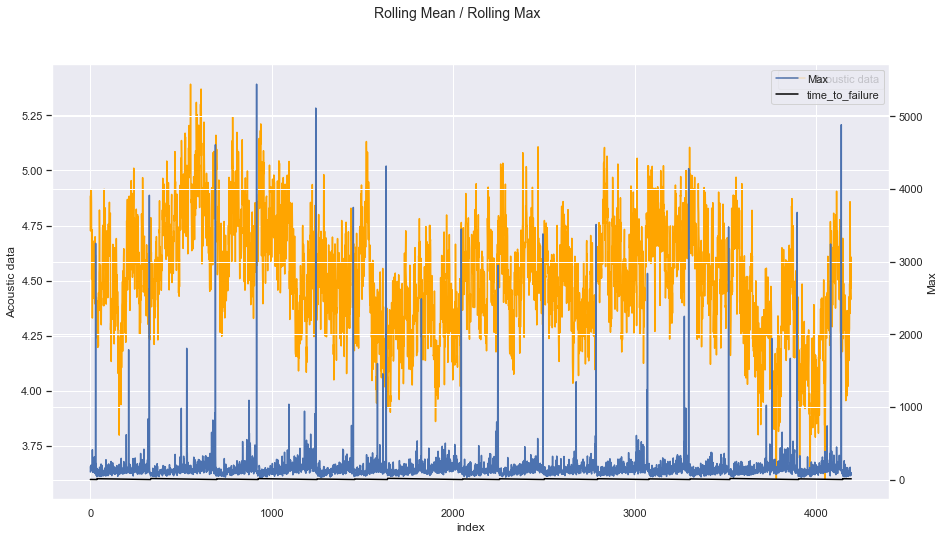

In [83]:
plot_triple_series(rolling_mean,'Acoustic data',rolling_max,'Max',last_time_to_failure,'index','Rolling Mean / Rolling Max')

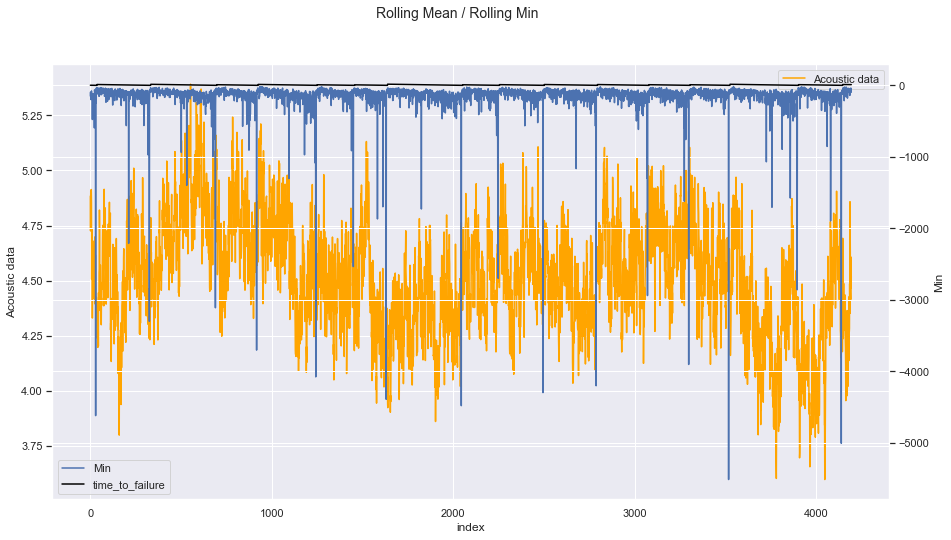

In [84]:
plot_triple_series(rolling_mean,'Acoustic data',rolling_min,'Min',last_time_to_failure,'index','Rolling Mean / Rolling Min')

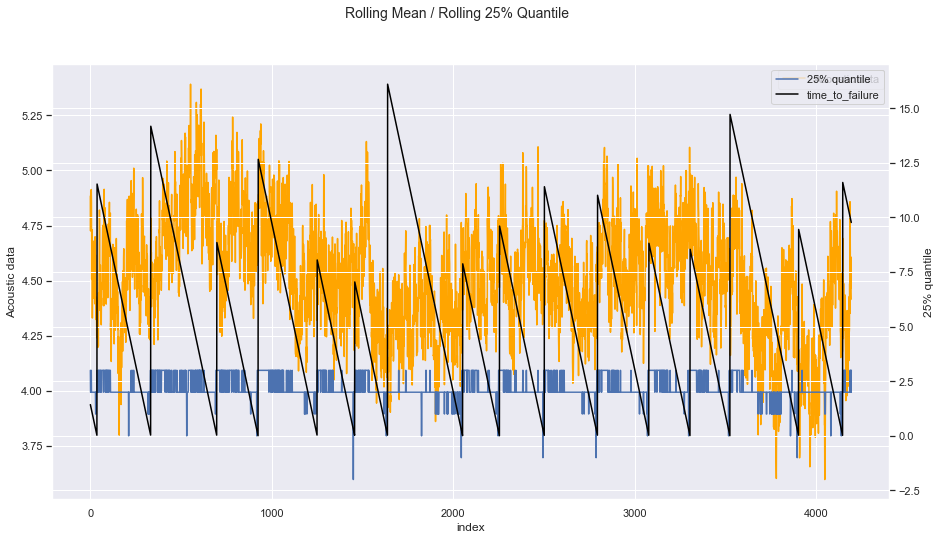

In [85]:
plot_triple_series(rolling_mean,'Acoustic data',rolling_25Quantile,'25% quantile',last_time_to_failure,'index','Rolling Mean / Rolling 25% Quantile')

## Autokorrelationen

In [11]:
print(acf(failure_reduced[0], nlags=100, fft=True))

[ 1.00000000e+00  3.69175691e-01 -2.96095504e-01 -2.72881204e-01
 -1.93279104e-01 -6.75089263e-02  1.47335858e-01 -8.98929590e-02
 -3.69069775e-01 -1.11024147e-01  2.04387544e-01  2.04102812e-01
  1.21463533e-01 -2.54623824e-02 -1.91395940e-01 -4.51759916e-02
  1.88686574e-01  1.17384884e-01 -5.83207685e-02 -1.02632890e-01
 -7.10223008e-02  3.03321504e-02  1.14718457e-01  5.62534381e-02
 -5.52428742e-02 -6.50646331e-02 -5.29887153e-03  3.38813572e-02
 -1.89236403e-02 -1.19745083e-01 -1.45656789e-01 -1.51072114e-02
  1.59789340e-01  2.12189733e-01  1.17753599e-01 -2.84725787e-02
 -1.07169184e-01 -6.96796212e-02 -3.43818214e-03 -1.27884699e-02
 -8.03382786e-02 -1.20892937e-01 -1.59513235e-02  1.37538742e-01
  1.58195024e-01  4.90341396e-02 -4.76586420e-02 -7.02205035e-02
 -4.81552434e-03  5.71166870e-02  9.20451547e-03 -8.26674262e-02
 -9.48430345e-02 -2.76077315e-02  4.64456035e-02  8.41504477e-02
  4.21158653e-02 -1.74763768e-02 -3.84746305e-03  3.32590060e-02
 -2.99960262e-03 -5.37891

<IPython.core.display.Javascript object>


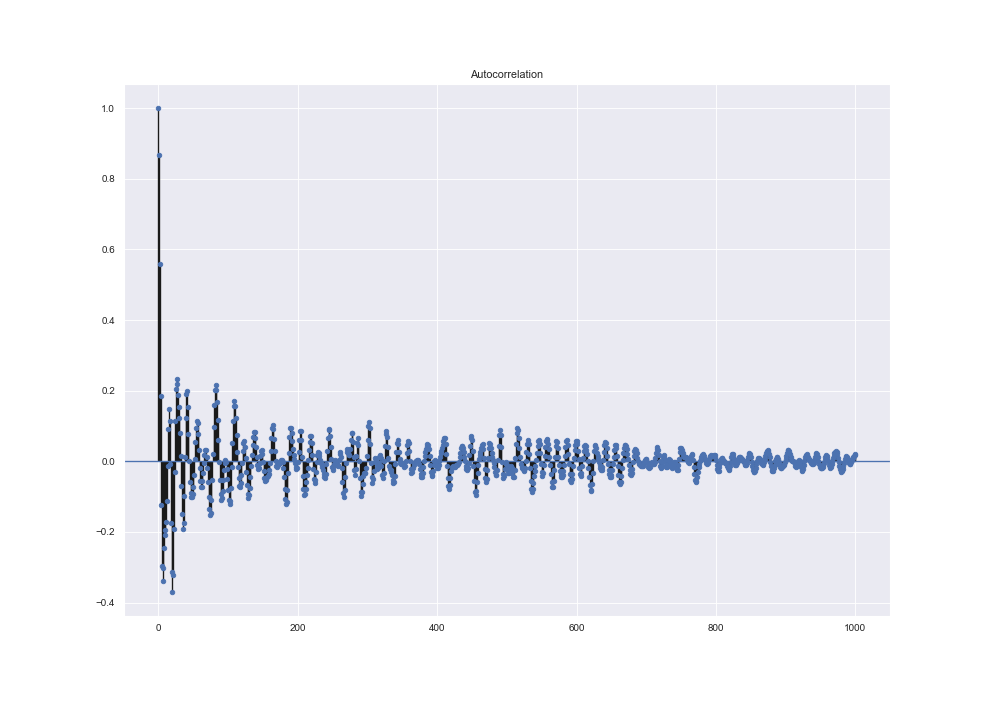

In [6]:
plot_acf(failure_reduced.acoustic_data,alpha=0.05,lags=1000)
plt.show()

# Erkenntnisse aus der Datenanalyse

## Stationarität der Trainingsdaten

Die Erdbeben aus den Trainingsdaten sind stationär (Dickey–Fuller und Kwiatkowski-Phillips-Schmidt-Shin test)

## Stationarität der Testdaten

## Muster in den Daten

### Standardabweichung

Muster: Je näher das Erdbeben umso mehr steigt die Std an. 

### Schiefe (Skweness)

Muster: Je näher das Erdbeben umso linksschiefer wird die Verteilung

## Erkenntnis

In [ ]:
Voraussagen mittels Machine learning sollten anhand der vorhandenen Muster möglich sein.

# ToDo

Stationaritätstest auf mehreren Erdbeben ausführen
Stationaritätstest auf den Testdaten ausführen
Testdaten anzeigen


Muster (Std./ Skew / Kurtosis) in den Daten besser herausarbeiten (siehe Bsp. https://www.kaggle.com/jsaguiar/seismic-data-exploration Standard deviation)

Tiefpassfilter um noise zu entfernen? -> gibt es einen Kernel dazu?